In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
from livelossplot import PlotLosses

In [2]:
class ImDataset(Dataset):
    
    def __init__(self, data, cuda):
        t = torch.from_numpy(data[:, 1:])
        t = t.type(torch.float32)
        t = t.cuda(cuda)
        self.x = t
        t = torch.from_numpy(data[:, [0]])
        t = t.type(torch.float32)
        t = t.cuda(cuda)
        self.y = t
        self.n_samples = data.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [3]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(32*32*3,3000)
        self.fc2 = torch.nn.Linear(3000, 350)
        self.fc3 = torch.nn.Linear(350,  1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [4]:
lossTrain = []
lossTest = []

test_size = 0.2 
batch_size = 0.2
num_epochs = 1000

In [5]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
    array_data = np.array(data)
    np.random.shuffle(array_data)
    split_index = int(np.floor(test_size * len(array_data)))
    train_data = array_data[:split_index]
    test_data = array_data[split_index:]
    
    dataset_train = ImDataset(train_data, torch.cuda.current_device())
    dataset_test = ImDataset(test_data, torch.cuda.current_device())
    
    dalaloader_train = DataLoader(dataset = dataset_train, batch_size = int(np.floor(batch_size * len(train_data))), shuffle = True, drop_last = True)

In [6]:
model = Net()
model.cuda(torch.cuda.current_device())

Net(
  (fc1): Linear(in_features=3072, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=1, bias=True)
)

In [7]:
criterion = torch.nn.L1Loss()

In [8]:
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.000001)

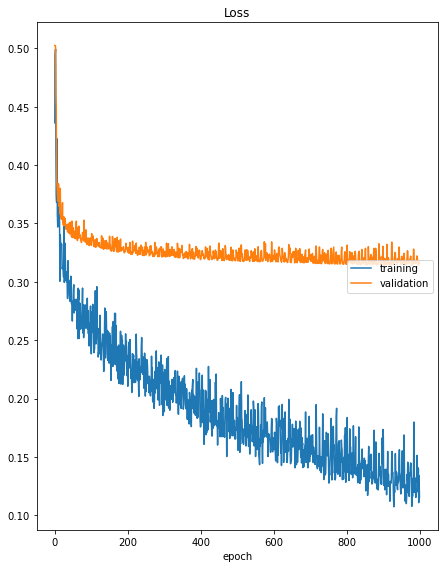

Loss
	training         	 (min:    0.107, max:    0.499, cur:    0.115)
	validation       	 (min:    0.314, max:    0.503, cur:    0.316)


In [9]:
liveloss = PlotLosses()
logs = {}
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(dalaloader_train):
        
        model.train()
        loss = criterion(model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        lossV = criterion(model(dataset_test.x), dataset_test.y) 
    logs['Loss'] = loss.item()
    logs['val_Loss'] = lossV.item()
    liveloss.update(logs)
    liveloss.send()

In [10]:
#plt.gca().set(xlim = (-1.0, np.floor(1 / batch_size) * num_epochs), ylim = (0, 1.0))
#plt.plot(lossTrain)
#plt.plot(lossTest)
#plt.xlabel("Epoch")
#plt.ylabel("Loss")        
#plt.legend(['Train', 'Test'])
#plt.savefig('graf.png')